In [ ]:
import tensorflow as tf
print(tf.__version__)  # should be 2.18.x or newer


2.19.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_root = "/content/drive/MyDrive/Data"


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:
img_size = (224, 224)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    os.path.join(data_root, "train"),
    image_size=img_size, batch_size=batch_size, label_mode="binary"
)
val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(data_root, "val"),
    image_size=img_size, batch_size=batch_size, label_mode="binary"
)
test_ds = keras.utils.image_dataset_from_directory(
    os.path.join(data_root, "test"),
    image_size=img_size, batch_size=batch_size, label_mode="binary"
)

class_names = train_ds.class_names
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


Found 1753 files belonging to 2 classes.
Found 3497 files belonging to 2 classes.
Found 634 files belonging to 2 classes.
Classes: ['normal', 'pneumonia']


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomContrast(0.1)
])

preprocess = layers.Rescaling(1./255)


In [ ]:
def build_baseline_cnn(input_shape=(224,224,3)):
    inputs = keras.Input(shape=input_shape)
    x = preprocess(inputs)
    x = data_augmentation(x)
    x = layers.Conv2D(32,3,activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128,3,activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128,activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1,activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name="baseline_cnn")

model = build_baseline_cnn()
model.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["accuracy", keras.metrics.AUC()])
model.summary()


Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 1021s 19s/step - accuracy: 0.7159 - auc: 0.7728 - loss: 0.5923 - val_accuracy: 0.8256 - val_auc: 0.9775 - val_loss: 0.3690
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 333s 6s/step - accuracy: 0.8578 - auc: 0.9415 - loss: 0.3072 - val_accuracy: 0.9019 - val_auc: 0.9801 - val_loss: 0.2376
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 339s 6s/step - accuracy: 0.8921 - auc: 0.9575 - loss: 0.2648 - val_accuracy: 0.8530 - val_auc: 0.9827 - val_loss: 0.3309
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 333s 6s/step - accuracy: 0.8939 - auc: 0.9637 - loss: 0.2450 - val_accuracy: 0.8828 - val_auc: 0.9852 - val_loss: 0.2857
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 361s 7s/step - accuracy: 0.8907 - auc: 0.9572 - loss: 0.2704 - val_accuracy: 0.8976 - val_auc: 0.9870 - val_loss: 0.2570


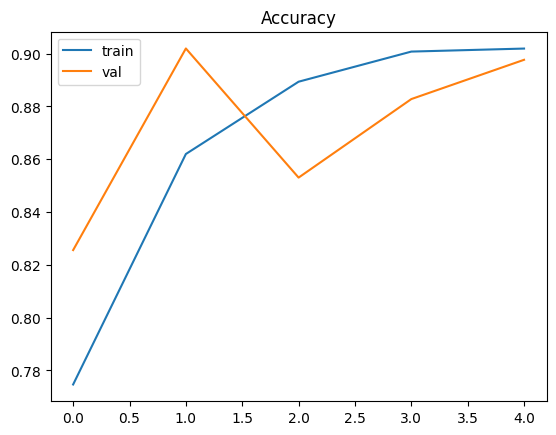

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# Plot training curves
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend(); plt.title("Accuracy"); plt.show()


In [ ]:
y_true, y_pred, y_prob = [], [], []

for X, y in test_ds:
    probs = model.predict(X).ravel()
    preds = (probs >= 0.5).astype(int)
    y_true.extend(y.numpy().astype(int))
    y_pred.extend(preds)
    y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print(classification_report(y_true, y_pred, target_names=class_names))
print("AUC:", roc_auc_score(y_true, y_prob))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
              precision    recall  f1-score   support

      normal       0.79      0.74      0.76       234
   pneumonia       0.85      0.89      0.87       400

    accuracy                           0.83       634
   macro avg    

In [ ]:
base = keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))
base.trainable = False   # Freeze backbone

inputs = keras.Input(shape=(224,224,3))
x = preprocess(inputs)
x = data_augmentation(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

vgg_model = keras.Model(inputs, outputs)
vgg_model.compile(optimizer="adam", loss="binary_crossentropy",
                  metrics=["accuracy", keras.metrics.AUC()])
vgg_model.fit(train_ds, validation_data=val_ds, epochs=5)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 3265s 60s/step - accuracy: 0.5010 - auc_1: 0.5010 - loss: 0.8188 - val_accuracy: 0.8487 - val_auc_1: 0.7945 - val_loss: 0.5852
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 3258s 60s/step - accuracy: 0.5676 - auc_1: 0.5785 - loss: 0.7016 - val_accuracy: 0.8725 - val_auc_1: 0.9166 - val_loss: 0.5495
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 3288s 61s/step - accuracy: 0.6250 - auc_1: 0.6880 - loss: 0.6415 - val_accuracy: 0.9019 - val_auc_1: 0.9320 - val_loss: 0.5218
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 3272s 60s/step - accuracy: 0.6977 - auc_1: 0.7820 - loss: 0.5983 - val_accuracy: 0.9056 - val_auc_1: 0.9396 - val_loss: 0.4920
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 3274s 60s/step - accuracy: 0.7407 - auc_1: 0.8321 - loss: 0.5693 - val_accuracy: 0.9102 - val_auc_1: 0.9436 - val_loss: 0.4745


In [ ]:
# Save your trained model
model.save("pneumonia_model.h5")

In [ ]:
model.save('pneumonia_model.keras')



In [ ]:
import numpy as np

# Example: run prediction on one sample
sample = np.expand_dims(x_test[0], axis=0)  # assuming you have x_test
prediction = loaded_model.predict(sample)

print("Prediction:", prediction)
print("True Label:", y_test[0])


NameError: name 'x_test' is not defined

In [ ]:
model.save('pneumonia_model.keras')`

SyntaxError: invalid syntax (ipython-input-2372833833.py, line 1)

In [ ]:
from google.colab import files
from PIL import Image

# Upload an image from your local system
uploaded = files.upload()

for filename in uploaded.keys():
    # Open the image
    img = Image.open(filename).convert("RGB")
    img_resized = img.resize((224,224))

    # Preprocess
    img_array = np.array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using baseline CNN or VGG16
    pred_prob = model.predict(img_array)[0][0]   # For baseline CNN
    # pred_prob = vgg_model.predict(img_array)[0][0]  # Or VGG16 model

    label = "Pneumonia" if pred_prob > 0.5 else "Normal"

    print(f"Prediction for {filename}: {label}")
    print(f"Confidence: {pred_prob:.2f}")

    # Display the uploaded image
    display(img)


Saving NORMAL2-IM-0303-0001 - Copy - Copy.jpeg to NORMAL2-IM-0303-0001 - Copy - Copy.jpeg


NameError: name 'model' is not defined